In [3]:
import sys
sys.path.append('../')
import re
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import json
from utils.rouge import RougeL
from utils.precision_recall_f1 import precision_recall_f1
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
matplotlib.style.use('ggplot')

## 保持全局长度下计算 label 的 ceil rougel

In [47]:
from utils.rouge import RougeL

ans_pattern = re.compile(r'@content\d@')

def find_answer_in_docid(answer):
    docs = ans_pattern.findall(answer)
    return list(set([int(doc[-2:-1]) for doc in docs]))

def calc_ceil_rougel(answer_text, sample):
    # 计算抽取的 fake answer 以及对应的 ceil rougel
    fake_answers = [sample['documents'][answer_label[0]]['content'][answer_label[1]: answer_label[2] + 1]
                    for answer_label in sample['answer_labels']]
    sample['fake_answers'] = fake_answers

    if len(fake_answers) == 0:
        sample['ceil_rougel'] = 0
    else:
        ceil_rougel = RougeL().add_inst(cand=''.join(fake_answers), ref=answer_text).get_score()
        sample['ceil_rougel'] = ceil_rougel


In [54]:
def calc_sample_ceil_rougel(sample):
    answer = sample['answer']
    ans_in_docids = find_answer_in_docid(answer)
    answer_texts = []
    for ans_in_docid in ans_in_docids:
        answer_strs = answer.split('@content{}@'.format(ans_in_docid))
        for answer_str in answer_strs:
            answer_str = answer_str.strip()  # important
            # @content1@ 包裹的实际答案文本
            if answer_str != '' and '@content' not in answer_str:
                answer_str = answer_str.replace('content{}@'.format(ans_in_docid), '')
                answer_texts.append(answer_str)

    # 拼接的答案文本
    answer_text = ''.join(answer_texts)
    calc_ceil_rougel(answer_text, sample)

In [99]:
ori_ceil_rougels = []

zero_ceil_rougel_samples = set()

with open('../input/mrc_dataset/train_round_0.json') as f:
    lines = f.readlines()
    for line in tqdm(lines):
        if not line.startswith('{'):
            continue

        sample = json.loads(line.strip())
        calc_sample_ceil_rougel(sample)
        ori_ceil_rougels.append(sample['ceil_rougel'])
        
        if sample['ceil_rougel'] == 0:
            zero_ceil_rougel_samples.add(sample['question_id'])

100%|██████████| 24843/24843 [00:09<00:00, 2584.14it/s]


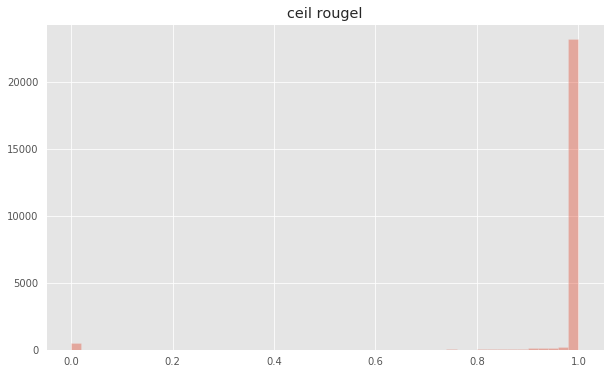

In [72]:
plt.figure(figsize=(10, 6))
sns.distplot(ori_ceil_rougels, kde=False)
plt.title('ceil rougel')
plt.show()

In [73]:
ori_ceil_rougels = np.array(ori_ceil_rougels)

In [74]:
print('total:', ori_ceil_rougels.shape[0])
print('ceil rougel < 0.20:', ori_ceil_rougels[ori_ceil_rougels < 0.2].shape[0])
print('ceil rougel > 0.95:', ori_ceil_rougels[ori_ceil_rougels > 0.95].shape[0])
print('ceil rougel = 0:', ori_ceil_rougels[ori_ceil_rougels == 0].shape[0])
print('ceil rougel = 1:', ori_ceil_rougels[ori_ceil_rougels == 1].shape[0])

total: 24843
ceil rougel < 0.20: 515
ceil rougel > 0.95: 23511
ceil rougel = 0: 498
ceil rougel = 1: 23117


In [75]:
ori_ceil_rougels[ori_ceil_rougels == 1].shape[0] / ori_ceil_rougels.shape[0]

0.930523688765447

In [77]:
np.mean(ori_ceil_rougels)

0.971559387448041

In [100]:
len(zero_ceil_rougel_samples)

498

In [101]:
# 生成 label 之前的 cleaned 数据

cleaned_bad_case_samples = []
for i in range(10):
    path = '../input/cleaned/split_train_0{}'.format(i)
    if not os.path.isfile(path):
        continue

    with open(path) as f:
        print(path)
        for line in f:
            sample = json.loads(line.strip())
            if sample['question_id'] in zero_ceil_rougel_samples:
                cleaned_bad_case_samples.append(line)


../input/cleaned/split_train_00
../input/cleaned/split_train_01
../input/cleaned/split_train_02
../input/cleaned/split_train_03
../input/cleaned/split_train_04
../input/cleaned/split_train_05
../input/cleaned/split_train_06
../input/cleaned/split_train_07
../input/cleaned/split_train_08
../input/cleaned/split_train_09


In [102]:
with open('cleaned_bad_case_samples.json', 'w', encoding='utf8') as f:
    f.writelines(cleaned_bad_case_samples)

## 采样扩充后的 ceil rougel

In [64]:
ceil_rougels = []

with open('../input/mrc_dataset/trainset/sample_aug_train_round_0.json') as f:
    for line in f:
        sample = json.loads(line.strip())
        ceil_rougels.append(sample['ceil_rougel'])

In [65]:
ceil_rougels = np.array(ceil_rougels)

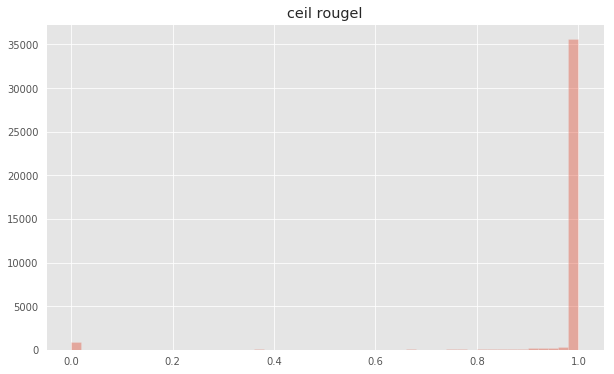

In [66]:
plt.figure(figsize=(10, 6))
sns.distplot(ceil_rougels, kde=False)
plt.title('ceil rougel')
plt.show()

In [67]:
print('total:', ceil_rougels.shape[0])
print('ceil rougel < 0.20:', ceil_rougels[ceil_rougels < 0.2].shape[0])
print('ceil rougel > 0.95:', ceil_rougels[ceil_rougels > 0.95].shape[0])
print('ceil rougel = 0:', ceil_rougels[ceil_rougels == 0].shape[0])
print('ceil rougel = 1:', ceil_rougels[ceil_rougels == 1].shape[0])

total: 38431
ceil rougel < 0.20: 892
ceil rougel > 0.95: 36111
ceil rougel = 0: 862
ceil rougel = 1: 35534


In [68]:
ceil_rougels[ceil_rougels == 1].shape[0] / ceil_rougels.shape[0]

0.924618146808566

In [69]:
np.mean(ceil_rougels)

0.9669466833516362

In [91]:
a="6月21日，中共中央政治局委员、中央政法委书记郭声琨在里斯本会见葡萄牙代总理席尔瓦外长。6月21日，中共中央政治局委员、中央政法委书记郭声琨在里斯本会见葡萄牙代总理席尔瓦外长。 摄影 郝帆郭声琨说，去年底以来，习近平主席和德索萨总统在不到半年时间内实现互访，体现了中葡关系的高水平发展，也为双边关系发展注入了新动力。中方愿同葡方携手努力，以两国建交40周年为契机，落实两国领导人达成的重要共识，密切高层交往，深化共建“一带一路”以及经贸、教育、科技等领域交流与合作，保持双边关系发展积极势头。双方要加强在中国—欧盟合作框架下和多边机构中沟通与协调，推动中欧关系长期健康稳定发展，共同维护多边主义和自由贸易。郭声琨表示，执法安全合作是两国关系的重要组成部分。两国执法安全部门要适应经贸和人员联系密切、安全利益保护需求上升的新形势，建立常态化合作机制，不断提升执法安全和反恐合作水平，为推动中葡全面战略伙伴关系发展作出积极贡献。席尔瓦以代总理身份欢迎郭声琨到访，转达正在国外访问的科斯塔总理对郭声琨的问候，高度评价葡中两国在各领域交流合作所取得的丰硕成果。表示葡方支持并积极参与共建“一带一路”，愿与中方共同努力，继续深挖经贸、执法安全等领域务实合作潜力，加强在国际事务中的协调，推动欧中、葡中关系不断向前发展。访问期间，郭声琨还与葡方执法安全部门负责人举行了会谈。中央政法委秘书长陈一新，驻葡萄牙大使蔡润，外交部涉外安全事务专员程国平，公安部副部长杜航伟，国家安全部副部长王裕文参加上述活动。"

In [92]:
a[208:233]

'“一带一路”以及经贸、教育、科技等领域交流与合作，'